---------
# CMSE 831 - Project


---------
### 1. Import Data

In [66]:
import pandas as pd

# Load the provided data
file_path = 'final_df.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataframe to understand its structure
df.head()

,Edge_ID,Start_Node_ID,End_Node_ID,L2_Distance,Start_Longitude,Start_Latitude,End_Longitude,End_Latitude
0,0,0,1,0.002025,-121.904167,41.974556,-121.902153,41.974766
1,1,0,6,0.005952,-121.904167,41.974556,-121.910088,41.973942
2,2,1,2,0.014350,-121.902153,41.974766,-121.896790,41.988075
3,3,2,3,0.012279,-121.896790,41.988075,-121.889603,41.998032
4,4,3,4,0.011099,-121.889603,41.998032,-121.886681,42.008739


---------
### 2. Calcalate Capacity

In [67]:
# Assumptions for capacity calculation
average_vehicle_length = 5  # in meters (average length of a passenger car)
safe_following_distance = 2  # in seconds (common safe following distance)
average_speed = 13.9  # in m/s (50 km/h, a common urban road speed)

# Calculate the safe distance in meters (using the 2-second rule)
safe_distance_meters = average_speed * safe_following_distance

# Total space occupied by one car (vehicle length + safe following distance)
total_space_per_car = average_vehicle_length + safe_distance_meters

# Adding an additional column for capacity estimation in the dataframe * Scale Up
df['Road_Capacity'] = df['L2_Distance']*100*1000 / total_space_per_car

# Display the first few rows of the dataframe with the new column
df.head()

,Edge_ID,Start_Node_ID,End_Node_ID,L2_Distance,Start_Longitude,Start_Latitude,End_Longitude,End_Latitude,Road_Capacity
0,0,0,1,0.002025,-121.904167,41.974556,-121.902153,41.974766,6.173780
1,1,0,6,0.005952,-121.904167,41.974556,-121.910088,41.973942,18.146341
2,2,1,2,0.014350,-121.902153,41.974766,-121.896790,41.988075,43.750000
3,3,2,3,0.012279,-121.896790,41.988075,-121.889603,41.998032,37.435976
4,4,3,4,0.011099,-121.889603,41.998032,-121.886681,42.008739,33.838415



I have calculated an estimated road capacity for each edge in your data. This estimate is based on the following assumptions:

1. Average Vehicle Length: 5 meters (typical length for a passenger car).
2. Safe Following Distance: 2 seconds, which is a common guideline for safety.
3. Average Speed: 13.9 m/s (equivalent to 50 km/h), a typical speed for urban roads.

The capacity is estimated by dividing the L2 distance of each road segment by the total space occupied by one car (which includes the length of the car and the safe following distance). This gives us an estimate of how many cars can fit on that segment of the road under ideal conditions.

---------
### 3. Create a subset of data

Data is too big to handle, so trim the data with reasonable size.


In [68]:
# Select most crowded area in California - Bay Area in San Francisco (approximately, bur from Wikipedia)
# Ended up setting wider area due to no path found...
min_latitude, max_latitude = 35, 40
min_longitude, max_longitude = -124, -118

# Make a subset for the bay area
df_bay = df[(df['Start_Latitude'].between(min_latitude, max_latitude)) & 
            (df['End_Latitude'].between(min_latitude, max_latitude)) & 
            (df['Start_Longitude'].between(min_longitude, max_longitude)) & 
            (df['End_Longitude'].between(min_longitude, max_longitude))
        ]

In [69]:
df_bay.shape

(10735, 9)

In [70]:
df_bay.head(3)

,Edge_ID,Start_Node_ID,End_Node_ID,L2_Distance,Start_Longitude,Start_Latitude,End_Longitude,End_Latitude,Road_Capacity
3431,3431,3372,3823,0.004429,-123.980110,40.0,-123.977913,39.996155,13.503049
3433,3433,3374,3596,0.007401,-123.617882,40.0,-123.617889,39.992599,22.564024
3453,3453,3394,3671,0.003453,-123.373909,40.0,-123.370811,39.998474,10.527439


In [71]:
# Select metropolitan area in California - LA Long Beach (approximately, but from Wikipedia)
# Ended up setting wider area due to no path found...
min_latitude, max_latitude = 32, 35 #33.5, 34
min_longitude, max_longitude = -118, -117 #-118.3, -118.2

# Make a subset for the bay area
df_lb = df[(df['Start_Latitude'].between(min_latitude, max_latitude)) & 
            (df['End_Latitude'].between(min_latitude, max_latitude)) & 
            (df['Start_Longitude'].between(min_longitude, max_longitude)) & 
            (df['End_Longitude'].between(min_longitude, max_longitude))
        ]

#33.8726° N, 118.2848° W # 34°03′N 118°15′W

In [72]:
df_lb.shape

(1885, 9)

---------
### 4. Plot the original flow

### 4.1. Graph with location info

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt

# Revising the provided code to fix the location of nodes using longitude and latitude

# Recreating the graph with the revised road capacity values
G = nx.Graph()

for _, row in df_lb.iterrows():
    # Add nodes
    G.add_node(row['Start_Node_ID'], type='StartNode')
    G.add_node(row['End_Node_ID'], type='EndNode')
    # Add edges
    G.add_edge(row['Start_Node_ID'], row['End_Node_ID'], capacity=row['Road_Capacity'], weight=row['L2_Distance'])
    # Bidirections
    G.add_edge(row['End_Node_ID'], row['Start_Node_ID'], capacity=row['Road_Capacity'], weight=row['L2_Distance'])

    
# Creating a dictionary to map node IDs to their corresponding longitude and latitude
node_positions = {}
for _, row in df_lb.iterrows():
    node_positions[row['Start_Node_ID']] = (row['Start_Longitude'], row['Start_Latitude'])
    node_positions[row['End_Node_ID']] = (row['End_Longitude'], row['End_Latitude'])

# Plotting the graph with fixed positions based on longitude and latitude
plt.figure(figsize=(12, 8))
nx.draw(G, pos=node_positions, with_labels=True, node_color='lightblue', node_size=100, edge_color='gray', font_size=5)
plt.title("Graph Representation of Road Network (LA Long Beach)")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


### 4.2. Graph without location info

In [ ]:
# Probably before applying maximum flow???

# Plotting the graph
plt.figure(figsize=(12, 8))
nx.draw(G, with_labels=True, node_color='lightblue', node_size=100, edge_color='gray', font_size=5, font_weight='medium')
plt.title("Graph Representation of df_bay")
plt.show()

---------
### 5. Set the Source and Sink

In [74]:
# Shleters? -> the right-hand side edges? --> Right side means high longitude

# Define threshold to specify shelters.
shelter_longitude_threshold = df_lb['End_Longitude'].quantile(0.80)
source_longitude_threshold = df_lb['End_Longitude'].quantile(0.20)

# Filter the nodes
shelter_nodes = df_lb[df_lb['End_Longitude'] >= shelter_longitude_threshold]
source_nodes = df_lb[df_lb['End_Longitude'] <= source_longitude_threshold]

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

# Base Graph
G = nx.Graph()

# Draw nodes and edges
for _, row in df_lb.iterrows():
    # Add nodes
    G.add_node(row['Start_Node_ID'], type='StartNode')
    G.add_node(row['End_Node_ID'], type='EndNode')
    # Add edges
    G.add_edge(row['Start_Node_ID'], row['End_Node_ID'], capacity=row['Road_Capacity'], weight=row['L2_Distance'])
    # Bidirection
    G.add_edge(row['End_Node_ID'], row['Start_Node_ID'], capacity=row['Road_Capacity'], weight=row['L2_Distance'])
    
# Set node positions to map the locations with the node Ids
node_positions = {}
for _, row in df_lb.iterrows():
    node_positions[row['Start_Node_ID']] = (row['Start_Longitude'], row['Start_Latitude'])
    node_positions[row['End_Node_ID']] = (row['End_Longitude'], row['End_Latitude'])

# Lists of shelter and source nodes -> to be used in the plot
shelter_nodes_list = shelter_nodes['End_Node_ID'].tolist()
source_nodes_list = source_nodes['End_Node_ID'].tolist()

# Create a list of colors for each node
node_colors = ['red' if node in shelter_nodes_list else 'blue' if node in source_nodes_list else 'lightblue' for node in G.nodes()]

# Plotting the graph with fixed positions based on longitude and latitude
plt.figure(figsize=(12, 8))
nx.draw(G, pos=node_positions, with_labels=True, node_color=node_colors, node_size=100, edge_color='gray', font_size=5)
plt.title("Graph Representation of Bay Area Road Network")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()

In [ ]:
# For each source node
for source in source_nodes_list:
    # For each shelter node
    for shelter in shelter_nodes_list:
        # Find the optimal (shortest) path from the source to the shelter
        try:
            path = nx.dijkstra_path(G, source, shelter, weight='weight')
            print(f"The optimal path from source {source} to shelter {shelter}: {path}")
        except nx.NetworkXNoPath:
            pass

In [ ]:
# For each source node
for source in source_nodes_list[:10]:
    # For each shelter node
    for sink in shelter_nodes_list[:10]:
        # Find the optimal (shortest) path from the source to the shelter
        try:
            flow_value, flow_dict = nx.maximum_flow(G, source, sink, capacity='capacity')
            print(f"Maximum flow: {flow_value}")
            print(f"Flow values by edge: {flow_dict}")
        except nx.NetworkXNoPath:
            pass

In [29]:
source_nodes_list[:10]

[15262, 15263, 15264, 15265, 15266, 15267, 15366, 16090, 15365, 15366]

In [30]:
shelter_nodes_list[:10]

[15277, 15294, 15305, 15278, 15279, 15280, 15281, 15282, 15295, 15296]

In [77]:
source = 15262
sink = 15277

flow_value, flow_dict = nx.maximum_flow(G, source, sink, capacity='capacity') # added capacity constraint

In [32]:
print(f"Maximum flow: {flow_value}")
print(f"Flow values by edge: {flow_dict}")

Maximum flow: 7.5548780487804885
Flow values by edge: {15098.0: {15262.0: 0}, 15262.0: {15098.0: 0, 15263.0: 7.5548780487804885}, 15099.0: {15209.0: 0}, 15209.0: {15099.0: 0, 15210.0: 0, 15259.0: 7.5548780487804885, 16491.0: 0}, 15210.0: {15209.0: 0, 15211.0: 0}, 15259.0: {15209.0: 0, 15258.0: 7.5548780487804885}, 16491.0: {15209.0: 7.5548780487804885, 16490.0: 0}, 15211.0: {15210.0: 0, 15212.0: 0}, 15212.0: {15211.0: 0, 15213.0: 0}, 15213.0: {15212.0: 0}, 15255.0: {15256.0: 0, 15304.0: 7.5548780487804885, 15625.0: 0}, 15256.0: {15255.0: 7.5548780487804885, 15257.0: 0}, 15304.0: {15255.0: 0, 15303.0: 7.5548780487804885}, 15625.0: {15255.0: 0, 15626.0: 0}, 15257.0: {15256.0: 7.5548780487804885, 15258.0: 0}, 15258.0: {15257.0: 7.5548780487804885, 15259.0: 0}, 15263.0: {15262.0: 0, 15264.0: 7.5548780487804885}, 15264.0: {15263.0: 0, 15265.0: 7.5548780487804885}, 15265.0: {15264.0: 0, 15266.0: 7.5548780487804885}, 15266.0: {15265.0: 0, 15267.0: 7.5548780487804885}, 15267.0: {15266.0: 0, 15

---------
### 6. Result after applying maximum flow

### 6.1. Graph with location info

In [ ]:
# Assuming that the variable 'flow_dict' contains the flow information for each edge
# Since 'flow_dict' is not provided, this part of the code is hypothetical

# Creating a color map based on the flow
edge_colors = []
for u, v in G.edges():
    flow = flow_dict[u][v]  # Retrieve actual flow data
    if flow > 0:
        edge_colors.append('red')  # Flow is present
    else:
        edge_colors.append('gray')  # No flow

# Plotting the graph with fixed positions based on longitude and latitude
plt.figure(figsize=(12, 8))
nx.draw(G, pos=node_positions, with_labels=True, edge_color=edge_colors, width=2, 
        node_color='lightblue', node_size=100, font_size=1)
plt.title("Graph with Maximum Flow Highlighted")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.grid(True)
plt.show()


### 6.2. Graph without location info

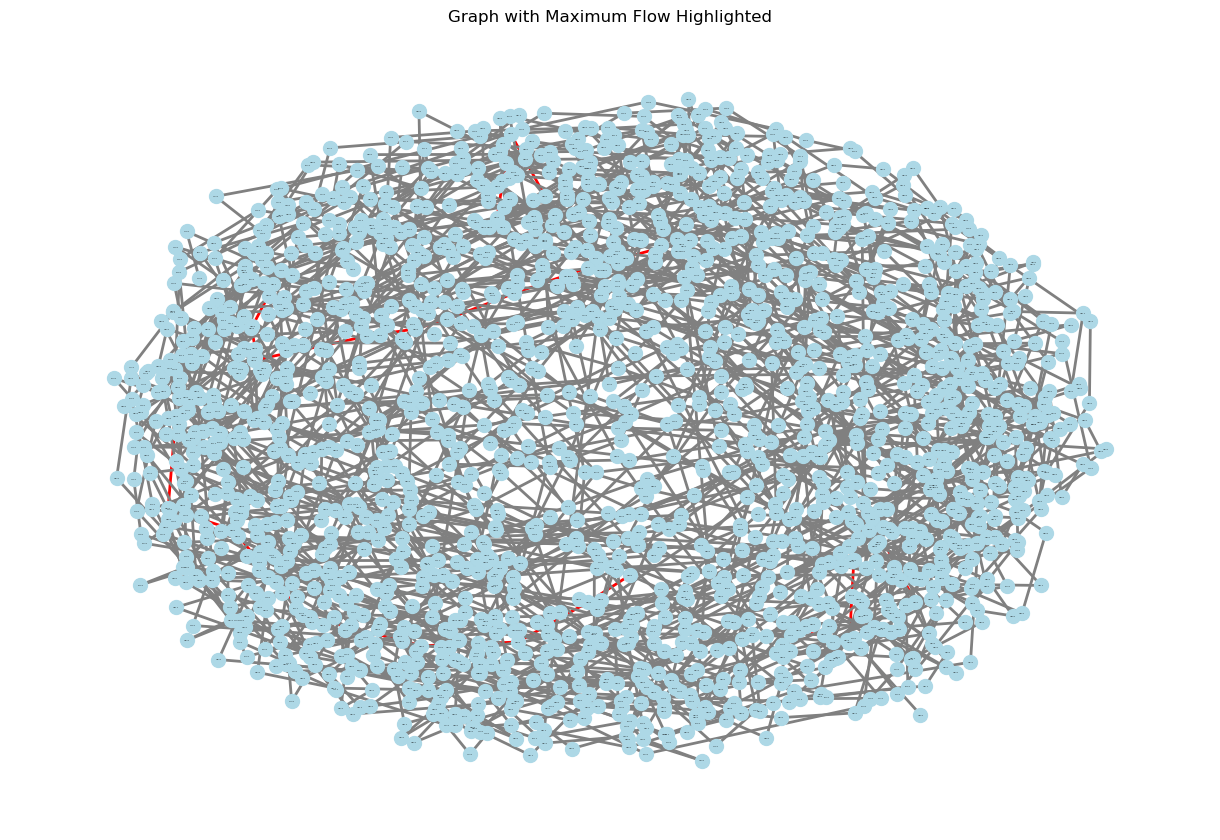

In [36]:
# Probably after applying maximum flow???

# Create a color map based on the flow
edge_colors = []
for u, v in G.edges():
    flow = flow_dict[u][v]
    if flow > 0:
        edge_colors.append('red')  # Flow is present
    else:
        edge_colors.append('gray') # No flow

# Plot the graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G)  # Positions for all nodes
nx.draw(G, pos, with_labels=True, edge_color=edge_colors, width=2, 
        node_color='lightblue', node_size=100, font_size=1)
plt.title("Graph with Maximum Flow Highlighted")
plt.show()


# In this plot, edges where flow occurs are colored red, and other edges are black.
# This will help you visualize the path of the maximum flow from the source to the sink in your graph.

In [43]:
print("Maximum flow value:", flow_value)
print("Flow along each path:", flow_dict)

Maximum flow value: 0.0001819207317073171
Flow along each path: {0.0: {1.0: 0, 6.0: 0}, 1.0: {2.0: 0}, 6.0: {}, 2.0: {3.0: 0}, 3.0: {4.0: 0}, 4.0: {}, 5.0: {6.0: 0, 7.0: 0, 8.0: 0}, 7.0: {265.0: 0}, 8.0: {298.0: 0}, 265.0: {}, 298.0: {299.0: 0}, 9.0: {10.0: 0, 36.0: 0, 37.0: 0}, 10.0: {11.0: 0}, 36.0: {}, 37.0: {38.0: 0}, 11.0: {12.0: 0}, 12.0: {13.0: 0}, 13.0: {14.0: 0}, 14.0: {15.0: 0}, 15.0: {16.0: 0}, 16.0: {17.0: 0}, 17.0: {18.0: 0}, 18.0: {19.0: 0}, 19.0: {20.0: 0}, 20.0: {21.0: 0}, 21.0: {22.0: 0}, 22.0: {23.0: 0}, 23.0: {24.0: 0}, 24.0: {25.0: 0}, 25.0: {26.0: 0}, 26.0: {27.0: 0}, 27.0: {28.0: 0}, 28.0: {29.0: 0}, 29.0: {30.0: 0}, 30.0: {31.0: 0}, 31.0: {}, 32.0: {33.0: 0}, 33.0: {34.0: 0}, 34.0: {35.0: 0}, 35.0: {36.0: 0}, 38.0: {39.0: 0}, 39.0: {81.0: 0, 352.0: 0}, 81.0: {82.0: 0}, 352.0: {}, 40.0: {41.0: 0}, 41.0: {42.0: 0}, 42.0: {43.0: 0}, 43.0: {44.0: 0}, 44.0: {45.0: 0}, 45.0: {46.0: 0}, 46.0: {47.0: 0}, 47.0: {48.0: 0}, 48.0: {49.0: 0}, 49.0: {50.0: 0}, 50.0: {51.0: 0},

In [44]:
import csv

file_path = 'flow_data.csv'

with open(file_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Path', 'Flow'])
    for path, flow in flow_dict.items():
        writer.writerow([path, flow])
    writer.writerow(['Total Flow', flow_value])

## Representation Learning

In [11]:
print(f"Number of Nodes: {G.number_of_nodes()}, Number of Edges: {G.number_of_edges()}")

Number of Nodes: 1797, Number of Edges: 1885


In [13]:
G.remove_nodes_from(list(nx.isolates(G)))
print(f"Number of Nodes: {G.number_of_nodes()}, Number of Edges: {G.number_of_edges()}")

Number of Nodes: 1797, Number of Edges: 1885


In [14]:
# Nodes into integers

def encode_graph(Graph):
    nodes = [(n,d.get("type",None)) for n, d in Graph.nodes(data=True)]
    nodes_df = pd.DataFrame(nodes, columns=["id","type"]).reset_index()
    node2idx = dict(zip(nodes_df["id"],nodes_df["index"]))
    edges = [(node2idx[source], node2idx[target], d.get("type",None)) for source, target, d in Graph.edges(data=True)]
    edges_df = pd.DataFrame(edges, columns=["source","target","type"])
    return nodes_df, edges_df

In [15]:
nodes_df, edges_df = encode_graph(G)

In [16]:
print(f"Number of Nodes: {len(nodes_df)}, Number of Edges: {len(edges_df)}")

Number of Nodes: 1797, Number of Edges: 1885


In [17]:
edge_list = list(zip(edges_df["source"],edges_df["target"]))
edge_list[:5]

[(0, 1), (1, 16), (2, 3), (3, 4), (3, 5)]

In [18]:
G_r = nx.Graph(edge_list)

print(f"Number of Nodes: {G_r.number_of_nodes()}, Number of Edges: {G_r.number_of_edges()}")

Number of Nodes: 1797, Number of Edges: 1885


In [61]:
from node2vec import Node2Vec

node2vec = Node2Vec(G_r, dimensions=10, walk_length=5, num_walks=10, p=1, q=1, workers=4)

Computing transition probabilities:   0%|          | 0/1797 [00:00<?, ?it/s]

Generating walks (CPU: 4): 100%|██████████| 2/2 [00:00<00:00, 78.48it/s]


In [62]:
model = node2vec.fit(window=3, min_count=1, batch_words=4)

In [63]:
embeddings = model.wv

from sklearn.decomposition import PCA

embeddings_array = embeddings.vectors
pca = PCA(n_components=2)
principal_components = pca.fit_transform(embeddings_array)

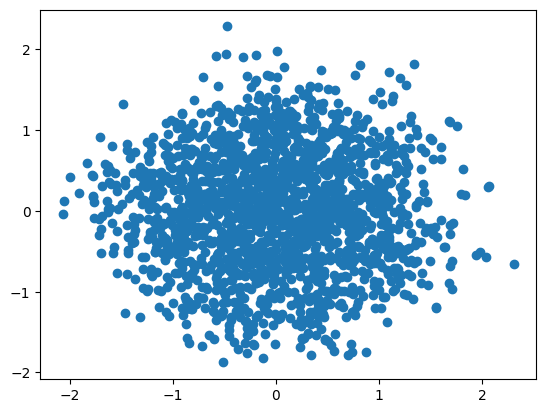

In [79]:
plt.scatter(principal_components[:, 0], principal_components[:, 1])

In [ ]:
# New graph with PCA result

G_new = nx.Graph()
    
for i, node_id in enumerate(nodes_df["id"]):
    G_new.add_node(i, type=nodes_df["type"][i])

for i, edge in edges_df.iterrows():
    G_new.add_edge(edge["source"], edge["target"], type=edge["type"])


plt.figure(figsize=(12, 8))

# updated positions
pos_new = {i: principal_components[i, :] for i in range(len(G_new.nodes()))}

# Nodes
nx.draw_networkx_nodes(G_new, pos_new, nodelist=G_new.nodes(), node_color='lightblue', node_size=50)

# Edges
nx.draw_networkx_edges(G_new, pos_new, edgelist=G_new.edges(), alpha=0.1)
plt.title('New Graph after PCA')
plt.show()

